In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="s4FZabiIIE2JRuSa8MFn")
project = rf.workspace("krishi-oz05i").project("agrifarm-3zwm0")
version = project.version(15)
dataset = version.download("png-mask-semantic")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 98.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to AGRIFARM-15 in png-mask-semantic:: 100%|██████████| 1724/1724 [00:01<00:00, 1356.27it/s]


In [2]:
import os
import shutil

# Original folder containing mixed files
src_dir = "/content/AGRIFARM-15/train"

# Destination folders
img_dest = "/content/train/images"
mask_dest = "/content/train/masks"

# Create destination folders if they don't exist
os.makedirs(img_dest, exist_ok=True)
os.makedirs(mask_dest, exist_ok=True)

# Move files
for f in os.listdir(src_dir):
    src_path = os.path.join(src_dir, f)
    if f.endswith(".jpg"):
        shutil.copy(src_path, os.path.join(img_dest, f))
    elif f.endswith("_mask.png"):
        shutil.copy(src_path, os.path.join(mask_dest, f))

print(f"✅ All images moved to {img_dest}")
print(f"✅ All masks moved to {mask_dest}")


✅ All images moved to /content/train/images
✅ All masks moved to /content/train/masks


In [3]:
import os
import shutil

# Original folder containing mixed files
src_dir = "/content/AGRIFARM-15/valid"

# Destination folders
img_dest = "/content/valid/images"
mask_dest = "/content/valid/masks"

# Create destination folders if they don't exist
os.makedirs(img_dest, exist_ok=True)
os.makedirs(mask_dest, exist_ok=True)

# Move files
for f in os.listdir(src_dir):
    src_path = os.path.join(src_dir, f)
    if f.endswith(".jpg"):
        shutil.copy(src_path, os.path.join(img_dest, f))
    elif f.endswith("_mask.png"):
        shutil.copy(src_path, os.path.join(mask_dest, f))

print(f"✅ All images moved to {img_dest}")
print(f"✅ All masks moved to {mask_dest}")


✅ All images moved to /content/valid/images
✅ All masks moved to /content/valid/masks


In [4]:
import os
import shutil

# Original folder containing mixed files
src_dir = "/content/AGRIFARM-15/test"

# Destination folders
img_dest = "/content/test/images"
mask_dest = "/content/test/masks"

# Create destination folders if they don't exist
os.makedirs(img_dest, exist_ok=True)
os.makedirs(mask_dest, exist_ok=True)

# Move files
for f in os.listdir(src_dir):
    src_path = os.path.join(src_dir, f)
    if f.endswith(".jpg"):
        shutil.copy(src_path, os.path.join(img_dest, f))
    elif f.endswith("_mask.png"):
        shutil.copy(src_path, os.path.join(mask_dest, f))

print(f"✅ All images moved to {img_dest}")
print(f"✅ All masks moved to {mask_dest}")


✅ All images moved to /content/test/images
✅ All masks moved to /content/test/masks


In [6]:
with open("/content/AGRIFARM-15/train/_classes.csv", "r") as f:
    classes = f.read().splitlines()

print(classes)

['Pixel Value, Class', '0, background', '1, Barrenland', '2, Bush', '3, Farmland', '4, Sand', '5, Tree', '6, edgecase']


In [ ]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.0 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import gc
from torch.cuda.amp import autocast, GradScaler

# ==========================================
# 1. CONFIGURATION
# ==========================================
CONFIG = {
    "ROOT_DIR": "/content",
    "IMG_SIZE": 512,
    "BATCH_SIZE": 8,
    "LR": 2e-4,
    "EPOCHS": 50,
    "NUM_CLASSES": 4,             # 0:Back, 1:Veg, 2:Farm, 3:Sand
    "IGNORE_INDEX": 255,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "MODEL_SAVE_PATH": "unetplusplus_b4_best.pth",
    "ENCODER": "efficientnet-b4",
    "ENCODER_WEIGHTS": "imagenet"
}

# ==========================================
# 2. DATASET (Refined Augmentations)
# ==========================================
class FarmDataset(Dataset):
    def __init__(self, root_dir, split="train"):
        self.img_dir = os.path.join(root_dir, split, "images")
        self.mask_dir = os.path.join(root_dir, split, "masks")

        # Check if directory exists to avoid errors if path is wrong
        if os.path.exists(self.img_dir):
            self.images = sorted([f for f in os.listdir(self.img_dir) if f.endswith('.jpg')])
        else:
            self.images = []
            print(f"Warning: Image directory {self.img_dir} not found.")

        if split == "train":
            self.transform = A.Compose([
                A.Resize(height=CONFIG['IMG_SIZE'], width=CONFIG['IMG_SIZE']),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                # Texture Augmentations
                A.RandomBrightnessContrast(p=0.4),
                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
                A.GaussNoise(p=0.2),
                # UPDATED: CoarseDropout with new API arguments
                A.CoarseDropout(num_holes_range=(1, 8), hole_height_range=(8, 32), hole_width_range=(8, 32), p=0.3),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
            ])
        else:
            self.transform = A.Compose([
                A.Resize(height=CONFIG['IMG_SIZE'], width=CONFIG['IMG_SIZE']),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = img_name.replace(".jpg", "_mask.png")
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))

        # 4-Class Mapping
        new_mask = np.zeros_like(mask)
        new_mask[(mask == 1) | (mask == 2) | (mask == 5)] = 1 # Veg
        new_mask[mask == 3] = 2 # Farm
        new_mask[mask == 4] = 3 # Sand
        new_mask[mask == 6] = CONFIG["IGNORE_INDEX"]
        new_mask[mask > 6] = CONFIG["IGNORE_INDEX"]

        augmentations = self.transform(image=image, mask=new_mask)
        return augmentations["image"], augmentations["mask"].long()

# ==========================================
# 3. LOSS FUNCTION
# ==========================================
class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice = smp.losses.DiceLoss(mode="multiclass", ignore_index=CONFIG["IGNORE_INDEX"])
        self.focal = smp.losses.FocalLoss(mode="multiclass", ignore_index=CONFIG["IGNORE_INDEX"])

    def forward(self, y_pred, y_true):
        return 0.4 * self.dice(y_pred, y_true) + 0.6 * self.focal(y_pred, y_true)

# ==========================================
# 4. METRICS (FIXED)
# ==========================================
def compute_metrics(preds, targets, num_classes, ignore_index=255):
    """Computes Mean IoU and Mean Dice ignoring the ignore_index"""
    pred_mask = torch.argmax(preds, dim=1)
    iou_list = []
    dice_list = []

    for c in range(num_classes):
        p_c = (pred_mask == c)
        t_c = (targets == c)

        valid_mask = (targets != ignore_index)
        p_c = p_c & valid_mask
        t_c = t_c & valid_mask

        intersection = (p_c & t_c).sum().float()
        union = (p_c | t_c).sum().float()
        dice_union = p_c.sum().float() + t_c.sum().float()

        # IoU Calculation
        if union == 0:
            iou = 1.0 if t_c.sum() == 0 else 0.0
        else:
            # Convert tensor to float item here
            iou = (intersection / (union + 1e-6)).item()

        # We strictly append the float value now
        iou_list.append(iou)

        # Dice Calculation
        if dice_union == 0:
            dice = 1.0 if t_c.sum() == 0 else 0.0
        else:
            # Convert tensor to float item here
            dice = ((2.0 * intersection) / (dice_union + 1e-6)).item()

        # We strictly append the float value now
        dice_list.append(dice)

    return np.mean(iou_list), np.mean(dice_list)

# ==========================================
# 5. TRAINING LOOP
# ==========================================
def train():
    torch.cuda.empty_cache()
    gc.collect()

    print(f"--- Training Unet++ with {CONFIG['ENCODER']} ---")

    model = smp.UnetPlusPlus(
        encoder_name=CONFIG['ENCODER'],
        encoder_weights=CONFIG['ENCODER_WEIGHTS'],
        in_channels=3,
        classes=CONFIG['NUM_CLASSES']
    ).to(CONFIG['DEVICE'])

    # Setup Datasets
    train_ds = FarmDataset(CONFIG['ROOT_DIR'], split="train")
    if len(train_ds) == 0:
        print("Error: No training images found. Check ROOT_DIR path.")
        return

    if os.path.exists(os.path.join(CONFIG['ROOT_DIR'], "valid")):
        val_ds = FarmDataset(CONFIG['ROOT_DIR'], split="valid")
    else:
        # Fallback if no specific valid folder exists
        print("No 'valid' folder found. Splitting train set...")
        train_size = int(0.85 * len(train_ds))
        val_size = len(train_ds) - train_size
        train_ds, val_ds = torch.utils.data.random_split(train_ds, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=2, pin_memory=True)

    criterion = CustomLoss()
    optimizer = AdamW(model.parameters(), lr=CONFIG['LR'], weight_decay=1e-3)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

    # GradScaler for AMP
    scaler = GradScaler()
    best_iou = 0.0

    for epoch in range(CONFIG['EPOCHS']):
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['EPOCHS']}")
        train_loss = 0

        for images, masks in loop:
            images = images.to(CONFIG['DEVICE'])
            masks = masks.to(CONFIG['DEVICE'])

            optimizer.zero_grad()

            # Mixed Precision Forward Pass
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)

            # Mixed Precision Backward Pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        scheduler.step()

        # Validation Loop
        model.eval()
        val_loss = 0
        ious = []
        dices = []

        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(CONFIG['DEVICE'])
                masks = masks.to(CONFIG['DEVICE'])

                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, masks)

                val_loss += loss.item()
                # Compute metrics (safe implementation)
                mIoU, mDice = compute_metrics(outputs, masks, CONFIG['NUM_CLASSES'], CONFIG['IGNORE_INDEX'])
                ious.append(mIoU)
                dices.append(mDice)

        avg_val_loss = val_loss / len(val_loader)
        avg_iou = np.mean(ious)
        avg_dice = np.mean(dices)

        print(f"Val Loss: {avg_val_loss:.4f} | mIoU: {avg_iou:.4f} | mDice: {avg_dice:.4f}")

        # Save Best Model
        if avg_iou > best_iou:
            print(f"🔥 Best IoU Improved ({best_iou:.4f} -> {avg_iou:.4f}). Saving model...")
            best_iou = avg_iou
            torch.save(model.state_dict(), CONFIG['MODEL_SAVE_PATH'])

if __name__ == "__main__":
    train()

--- Training Unet++ with efficientnet-b4 ---


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
Epoch 1/50: 100%|██████████| 88/88 [00:54<00:00,  1.61it/s, loss=0.478]
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Val Loss: 0.4460 | mIoU: 0.3953 | mDice: 0.4872
🔥 Best IoU Improved (0.0000 -> 0.3953). Saving model...


Epoch 2/50: 100%|██████████| 88/88 [00:55<00:00,  1.58it/s, loss=0.343]


Val Loss: 0.3549 | mIoU: 0.5036 | mDice: 0.5817
🔥 Best IoU Improved (0.3953 -> 0.5036). Saving model...


Epoch 3/50: 100%|██████████| 88/88 [00:56<00:00,  1.57it/s, loss=0.371]


Val Loss: 0.3657 | mIoU: 0.5300 | mDice: 0.6215
🔥 Best IoU Improved (0.5036 -> 0.5300). Saving model...


Epoch 4/50: 100%|██████████| 88/88 [00:56<00:00,  1.56it/s, loss=0.447]


Val Loss: 0.3396 | mIoU: 0.5539 | mDice: 0.6508
🔥 Best IoU Improved (0.5300 -> 0.5539). Saving model...


Epoch 5/50: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, loss=0.271]


Val Loss: 0.3396 | mIoU: 0.5624 | mDice: 0.6579
🔥 Best IoU Improved (0.5539 -> 0.5624). Saving model...


Epoch 6/50: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, loss=0.317]


Val Loss: 0.3457 | mIoU: 0.5624 | mDice: 0.6619
🔥 Best IoU Improved (0.5624 -> 0.5624). Saving model...


Epoch 7/50: 100%|██████████| 88/88 [00:56<00:00,  1.54it/s, loss=0.353]


Val Loss: 0.3436 | mIoU: 0.5623 | mDice: 0.6635


Epoch 8/50: 100%|██████████| 88/88 [00:57<00:00,  1.54it/s, loss=0.346]


Val Loss: 0.3218 | mIoU: 0.5604 | mDice: 0.6625


Epoch 9/50: 100%|██████████| 88/88 [00:56<00:00,  1.54it/s, loss=0.363]


Val Loss: 0.3316 | mIoU: 0.5990 | mDice: 0.6987
🔥 Best IoU Improved (0.5624 -> 0.5990). Saving model...


Epoch 10/50: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, loss=0.195]


Val Loss: 0.3361 | mIoU: 0.5774 | mDice: 0.6792


Epoch 11/50: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, loss=0.507]


Val Loss: 0.3492 | mIoU: 0.5968 | mDice: 0.6975


Epoch 12/50: 100%|██████████| 88/88 [00:57<00:00,  1.54it/s, loss=0.366]


Val Loss: 0.3469 | mIoU: 0.6170 | mDice: 0.7161
🔥 Best IoU Improved (0.5990 -> 0.6170). Saving model...


Epoch 13/50: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, loss=0.804]


Val Loss: 0.3051 | mIoU: 0.5696 | mDice: 0.6648


Epoch 14/50: 100%|██████████| 88/88 [00:57<00:00,  1.54it/s, loss=0.293]


Val Loss: 0.3192 | mIoU: 0.5795 | mDice: 0.6800


Epoch 15/50: 100%|██████████| 88/88 [00:57<00:00,  1.54it/s, loss=0.141]


Val Loss: 0.3377 | mIoU: 0.5601 | mDice: 0.6597


Epoch 16/50: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, loss=0.202]


Val Loss: 0.3315 | mIoU: 0.6027 | mDice: 0.6997


Epoch 17/50: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, loss=0.343]


Val Loss: 0.3614 | mIoU: 0.5681 | mDice: 0.6688


Epoch 18/50: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, loss=0.267]


Val Loss: 0.3620 | mIoU: 0.6125 | mDice: 0.7112


Epoch 19/50: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, loss=0.247]


Val Loss: 0.3648 | mIoU: 0.6009 | mDice: 0.7007


Epoch 20/50: 100%|██████████| 88/88 [00:57<00:00,  1.54it/s, loss=0.171]


Val Loss: 0.3760 | mIoU: 0.5767 | mDice: 0.6786


Epoch 21/50: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, loss=0.553]


Val Loss: 0.3827 | mIoU: 0.6035 | mDice: 0.6990


Epoch 22/50: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, loss=0.103]


Val Loss: 0.3578 | mIoU: 0.5802 | mDice: 0.6780


Epoch 23/50: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, loss=0.139]


Val Loss: 0.3591 | mIoU: 0.5567 | mDice: 0.6588


Epoch 24/50: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, loss=0.108]


Val Loss: 0.3522 | mIoU: 0.5821 | mDice: 0.6843


Epoch 25/50: 100%|██████████| 88/88 [00:57<00:00,  1.54it/s, loss=0.158]


Val Loss: 0.3526 | mIoU: 0.5548 | mDice: 0.6572


Epoch 26/50: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, loss=0.151]


Val Loss: 0.3564 | mIoU: 0.5622 | mDice: 0.6638


Epoch 27/50: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, loss=0.184]


Val Loss: 0.3754 | mIoU: 0.5611 | mDice: 0.6624


Epoch 28/50: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, loss=0.264]


Val Loss: 0.3940 | mIoU: 0.5813 | mDice: 0.6826


Epoch 29/50: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, loss=0.328]


Val Loss: 0.3809 | mIoU: 0.5536 | mDice: 0.6565


Epoch 30/50: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, loss=0.186]


Val Loss: 0.3854 | mIoU: 0.5617 | mDice: 0.6632


Epoch 31/50: 100%|██████████| 88/88 [00:57<00:00,  1.54it/s, loss=0.154]


Val Loss: 0.4088 | mIoU: 0.5321 | mDice: 0.6325


Epoch 32/50: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, loss=0.762]


Val Loss: 0.4403 | mIoU: 0.5713 | mDice: 0.6766


Epoch 33/50: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, loss=0.199]


Val Loss: 0.5384 | mIoU: 0.5563 | mDice: 0.6620


Epoch 34/50:  28%|██▊       | 25/88 [00:17<00:43,  1.45it/s, loss=0.341]


KeyboardInterrupt: 

--- Loading Model ---
Weights loaded successfully.
--- Displaying 6 Random Predictions ---


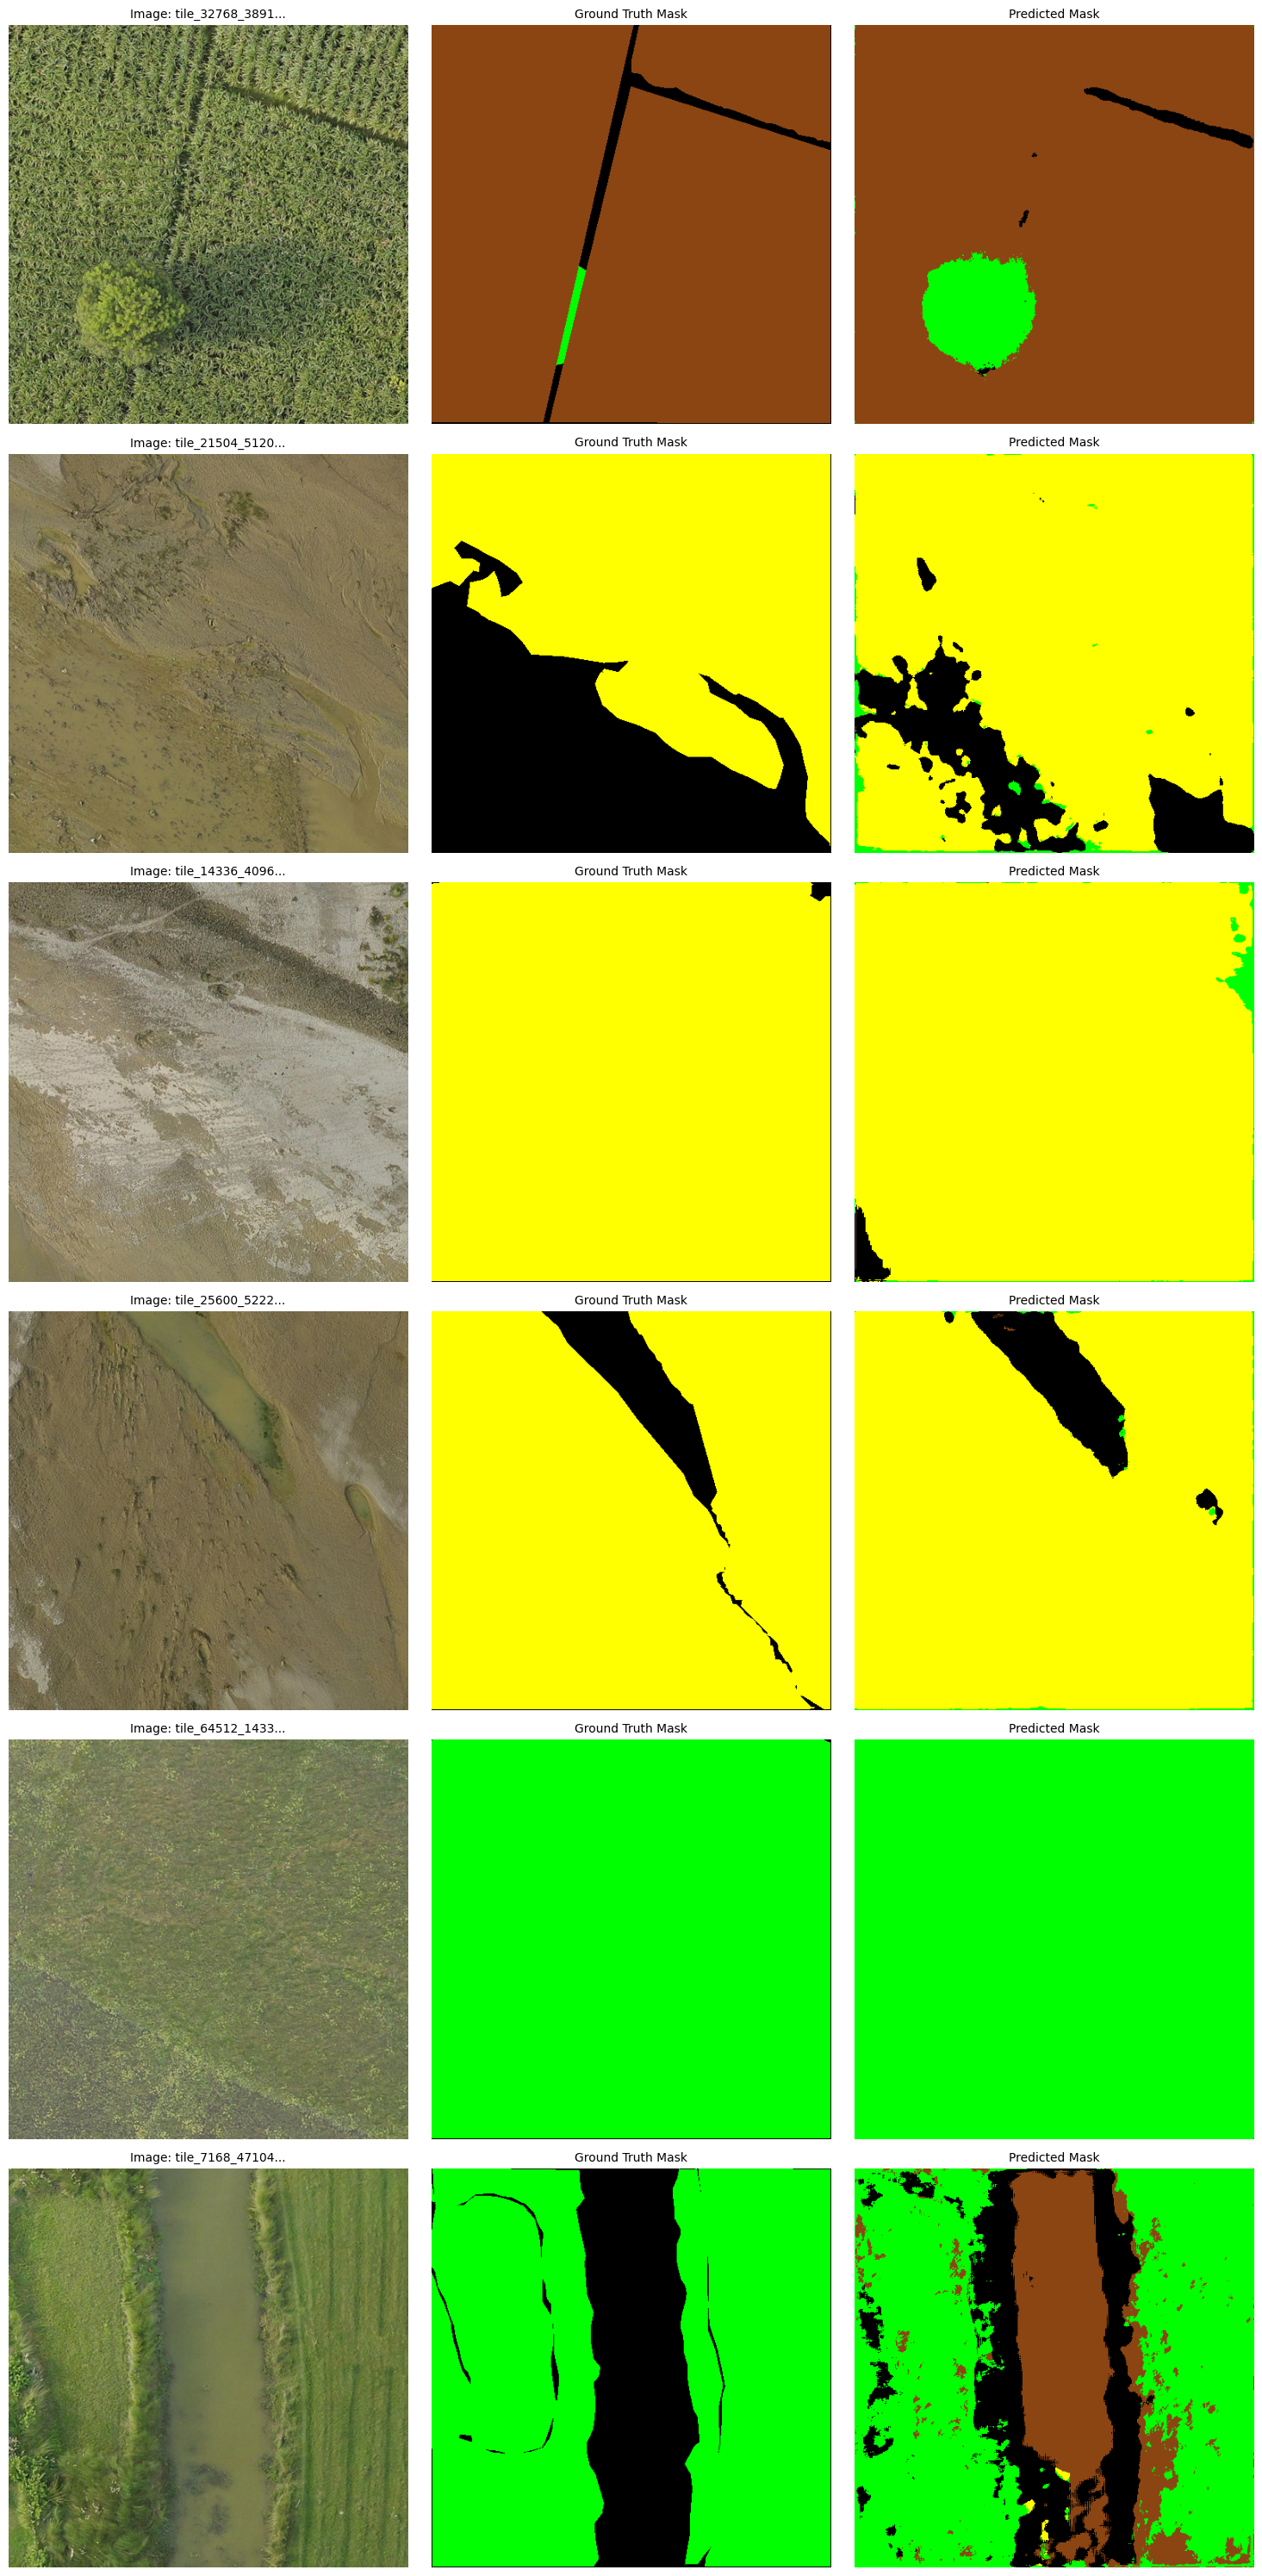


--- Color Legend ---
Background: [0 0 0]
Vegetation: [  0 255   0]
Farm: [139  69  19]
Sand: [255 255   0]


In [ ]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

# ==========================================
# 1. CONFIGURATION & SETUP
# ==========================================
CONFIG = {
    "ROOT_DIR": "/content/test",  # Path to test folder
    "IMG_SIZE": 512,
    "NUM_CLASSES": 4,             # 0:Back, 1:Veg, 2:Farm, 3:Sand
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "MODEL_PATH": "/content/models/unetplusplus_b4_best.pth", # Path to your saved model
    "ENCODER": "efficientnet-b4",
    "ENCODER_WEIGHTS": "imagenet"
}

# Define colors for visualization
# Format: [R, G, B]
CLASS_COLORS = np.array([
    [0, 0, 0],       # 0: Background (Black)
    [0, 255, 0],     # 1: Vegetation (Green)
    [139, 69, 19],   # 2: Farm (Brown)
    [255, 255, 0],   # 3: Sand (Yellow)
])

CLASS_NAMES = ["Background", "Vegetation", "Farm", "Sand"]

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================
def decode_segmap(mask):
    """
    Converts a 2D segmentation mask (H, W) with integer class IDs
    into an RGB image (H, W, 3) for visualization.
    """
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)

    for label_idx in range(CONFIG['NUM_CLASSES']):
        idx = (mask == label_idx)
        r[idx] = CLASS_COLORS[label_idx, 0]
        g[idx] = CLASS_COLORS[label_idx, 1]
        b[idx] = CLASS_COLORS[label_idx, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

def process_mask(mask_path):
    """
    Loads the raw mask and applies the same mapping logic used during training.
    """
    mask = np.array(Image.open(mask_path).convert("L"))

    new_mask = np.zeros_like(mask)
    # Apply exact mapping from Training Code
    new_mask[(mask == 1) | (mask == 2) | (mask == 5)] = 1 # Veg
    new_mask[mask == 3] = 2 # Farm
    new_mask[mask == 4] = 3 # Sand
    # Ignore indices (6 and above) will remain 0 (Background) for visualization
    # or you can handle them separately, but usually 0 is fine for inference display.

    return new_mask

def get_inference_transform():
    """Transform for input image only"""
    return A.Compose([
        A.Resize(height=CONFIG['IMG_SIZE'], width=CONFIG['IMG_SIZE']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

# ==========================================
# 3. INFERENCE LOOP
# ==========================================
def run_inference():
    print("--- Loading Model ---")
    # 1. Load Model Architecture
    model = smp.UnetPlusPlus(
        encoder_name=CONFIG['ENCODER'],
        encoder_weights=None, # Weights loaded manually below
        in_channels=3,
        classes=CONFIG['NUM_CLASSES']
    ).to(CONFIG['DEVICE'])

    # 2. Load Weights
    if os.path.exists(CONFIG['MODEL_PATH']):
        model.load_state_dict(torch.load(CONFIG['MODEL_PATH'], map_location=CONFIG['DEVICE']))
        print("Weights loaded successfully.")
    else:
        print(f"Error: Model path {CONFIG['MODEL_PATH']} not found!")
        return

    model.eval()
    transform = get_inference_transform()

    # 3. Get Test Images
    img_dir = os.path.join(CONFIG['ROOT_DIR'], "images")
    mask_dir = os.path.join(CONFIG['ROOT_DIR'], "masks")

    all_images = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])

    if len(all_images) == 0:
        print("No images found in test directory.")
        return

    # 4. Select Random Samples
    num_samples = min(6, len(all_images)) # Select 6 or fewer if dataset is small
    selected_images = random.sample(all_images, num_samples)

    print(f"--- Displaying {num_samples} Random Predictions ---")

    plt.figure(figsize=(15, 5 * num_samples))

    for i, img_name in enumerate(selected_images):
        mask_name = img_name.replace(".jpg", "_mask.png")
        img_path = os.path.join(img_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)

        # --- Preprocessing ---
        # Open Original for Display
        original_img = np.array(Image.open(img_path).convert("RGB"))
        original_img_resized = np.array(Image.fromarray(original_img).resize((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])))

        # Open Mask for GT Display
        if os.path.exists(mask_path):
            gt_mask_raw = process_mask(mask_path) # Apply mapping
            gt_mask_resized = np.array(Image.fromarray(gt_mask_raw).resize((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']), resample=Image.NEAREST))
            gt_rgb = decode_segmap(gt_mask_resized)
        else:
            gt_rgb = np.zeros((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], 3)) # Black if missing

        # Preprocess for Model
        augmentations = transform(image=original_img)
        input_tensor = augmentations["image"].unsqueeze(0).to(CONFIG['DEVICE']) # Add batch dim

        # --- Prediction ---
        with torch.no_grad():
            output = model(input_tensor) # Shape: [1, Num_Classes, H, W]
            # Apply Softmax/Argmax to get class indices
            pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

        # Convert Prediction to RGB
        pred_rgb = decode_segmap(pred_mask)

        # --- Plotting ---
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(original_img_resized)
        plt.title(f"Image: {img_name[:15]}...", fontsize=10)
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(gt_rgb)
        plt.title("Ground Truth Mask", fontsize=10)
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_rgb)
        plt.title("Predicted Mask", fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.savefig("inference_results.png")
    plt.show()

    # Print Legend
    print("\n--- Color Legend ---")
    for idx, name in enumerate(CLASS_NAMES):
        print(f"{name}: {CLASS_COLORS[idx]}")

if __name__ == "__main__":
    run_inference()

In [ ]:
import os
import torch
import numpy as np
from tqdm import tqdm
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ==========================================
# 1. CONFIGURATION (Define this at the top)
# ==========================================
CONFIG = {
    "ROOT_DIR": "/content",       # Change if your data is elsewhere
    "IMG_SIZE": 512,
    "BATCH_SIZE": 8,
    "NUM_CLASSES": 4,             # 0:Back, 1:Veg, 2:Farm, 3:Sand
    "IGNORE_INDEX": 255,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "MODEL_SAVE_PATH": "unetplusplus_b4_best.pth", # Ensure this matches your saved model name
    "ENCODER": "efficientnet-b4"
}

# ==========================================
# 2. DATASET (Needed to load data)
# ==========================================
class FarmDataset(Dataset):
    def __init__(self, root_dir, split="valid"):
        self.img_dir = os.path.join(root_dir, split, "images")
        self.mask_dir = os.path.join(root_dir, split, "masks")

        # Check path exists
        if os.path.exists(self.img_dir):
            self.images = sorted([f for f in os.listdir(self.img_dir) if f.endswith('.jpg')])
        else:
            self.images = []
            print(f"Warning: Image dir {self.img_dir} not found")

        # Validation/Test Transform (No flips/rotations, just resize/norm)
        self.transform = A.Compose([
            A.Resize(height=CONFIG['IMG_SIZE'], width=CONFIG['IMG_SIZE']),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = img_name.replace(".jpg", "_mask.png")
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))

        # Apply Mapping
        new_mask = np.zeros_like(mask)
        new_mask[(mask == 1) | (mask == 2) | (mask == 5)] = 1 # Veg
        new_mask[mask == 3] = 2 # Farm
        new_mask[mask == 4] = 3 # Sand
        new_mask[mask == 6] = CONFIG["IGNORE_INDEX"]
        new_mask[mask > 6] = CONFIG["IGNORE_INDEX"]

        augmentations = self.transform(image=image, mask=new_mask)
        return augmentations["image"], augmentations["mask"].long()

# ==========================================
# 3. METRIC CALCULATOR CLASS
# ==========================================
class MetricCalculator:
    def __init__(self, num_classes, device):
        self.num_classes = num_classes
        self.device = device
        self.confusion_matrix = torch.zeros((num_classes, num_classes), device=device, dtype=torch.long)

    def update(self, preds, targets):
        preds = preds.view(-1)
        targets = targets.view(-1)
        mask = (targets != CONFIG["IGNORE_INDEX"])
        preds = preds[mask]
        targets = targets[mask]
        indices = targets * self.num_classes + preds
        m = torch.bincount(indices, minlength=self.num_classes ** 2)
        self.confusion_matrix += m.reshape(self.num_classes, self.num_classes)

    def compute(self):
        cm = self.confusion_matrix.float()
        tp = torch.diag(cm)
        fp = cm.sum(dim=0) - tp
        fn = cm.sum(dim=1) - tp
        epsilon = 1e-7

        iou = tp / (tp + fp + fn + epsilon)
        precision = tp / (tp + fp + epsilon)
        recall = tp / (tp + fn + epsilon)
        dice = 2 * tp / (2 * tp + fp + fn + epsilon)

        return {
            "IoU": iou.cpu().numpy(),
            "Dice": dice.cpu().numpy(),
            "Precision": precision.cpu().numpy(),
            "Recall": recall.cpu().numpy()
        }

# ==========================================
# 4. EVALUATION FUNCTION
# ==========================================
def evaluate_model(split="valid"):
    print(f"--- Evaluating on '{split}' set ---")

    model = smp.UnetPlusPlus(
        encoder_name=CONFIG['ENCODER'],
        encoder_weights=None,
        in_channels=3,
        classes=CONFIG['NUM_CLASSES']
    ).to(CONFIG['DEVICE'])

    if os.path.exists(CONFIG['MODEL_SAVE_PATH']):
        model.load_state_dict(torch.load(CONFIG['MODEL_SAVE_PATH'], map_location=CONFIG['DEVICE']))
        print("Weights loaded.")
    else:
        print(f"Error: Weights file {CONFIG['MODEL_SAVE_PATH']} not found.")
        return

    model.eval()

    # Check if valid folder exists, otherwise split logic implies training code context
    # Here we assume dataset structure: /content/valid/images
    dataset = FarmDataset(CONFIG['ROOT_DIR'], split=split)
    if len(dataset) == 0: return

    loader = DataLoader(dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=2)
    metric_calc = MetricCalculator(CONFIG['NUM_CLASSES'], CONFIG['DEVICE'])

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Calculating Metrics"):
            images = images.to(CONFIG['DEVICE'])
            masks = masks.to(CONFIG['DEVICE'])
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            metric_calc.update(preds, masks)

    results = metric_calc.compute()
    class_names = ["Background", "Vegetation", "Farm", "Sand"]

    print("\n" + "="*80)
    print(f"{'Class':<15} | {'IoU':<10} | {'Dice/F1':<10} | {'Precision':<10} | {'Recall':<10}")
    print("-" * 80)

    for i, name in enumerate(class_names):
        print(f"{name:<15} | {results['IoU'][i]:.4f}     | {results['Dice'][i]:.4f}     | {results['Precision'][i]:.4f}     | {results['Recall'][i]:.4f}")

    print("-" * 80)
    print(f"{'MEAN':<15} | {np.mean(results['IoU']):.4f}     | {np.mean(results['Dice']):.4f}     | {np.mean(results['Precision']):.4f}     | {np.mean(results['Recall']):.4f}")
    print("="*80 + "\n")

if __name__ == "__main__":
    # Ensure you have a folder named 'valid' or change this to 'test'
    evaluate_model(split="test")

--- Evaluating on 'test' set ---
Weights loaded.


Calculating Metrics: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Class           | IoU        | Dice/F1    | Precision  | Recall    
--------------------------------------------------------------------------------
Background      | 0.5967     | 0.7475     | 0.7470     | 0.7479
Vegetation      | 0.7829     | 0.8782     | 0.8452     | 0.9139
Farm            | 0.8345     | 0.9098     | 0.9364     | 0.8845
Sand            | 0.7931     | 0.8846     | 0.8918     | 0.8776
--------------------------------------------------------------------------------
MEAN            | 0.7518     | 0.8550     | 0.8551     | 0.8560



--- Loading Model ---
Weights loaded successfully.
--- Displaying 6 Random Predictions ---


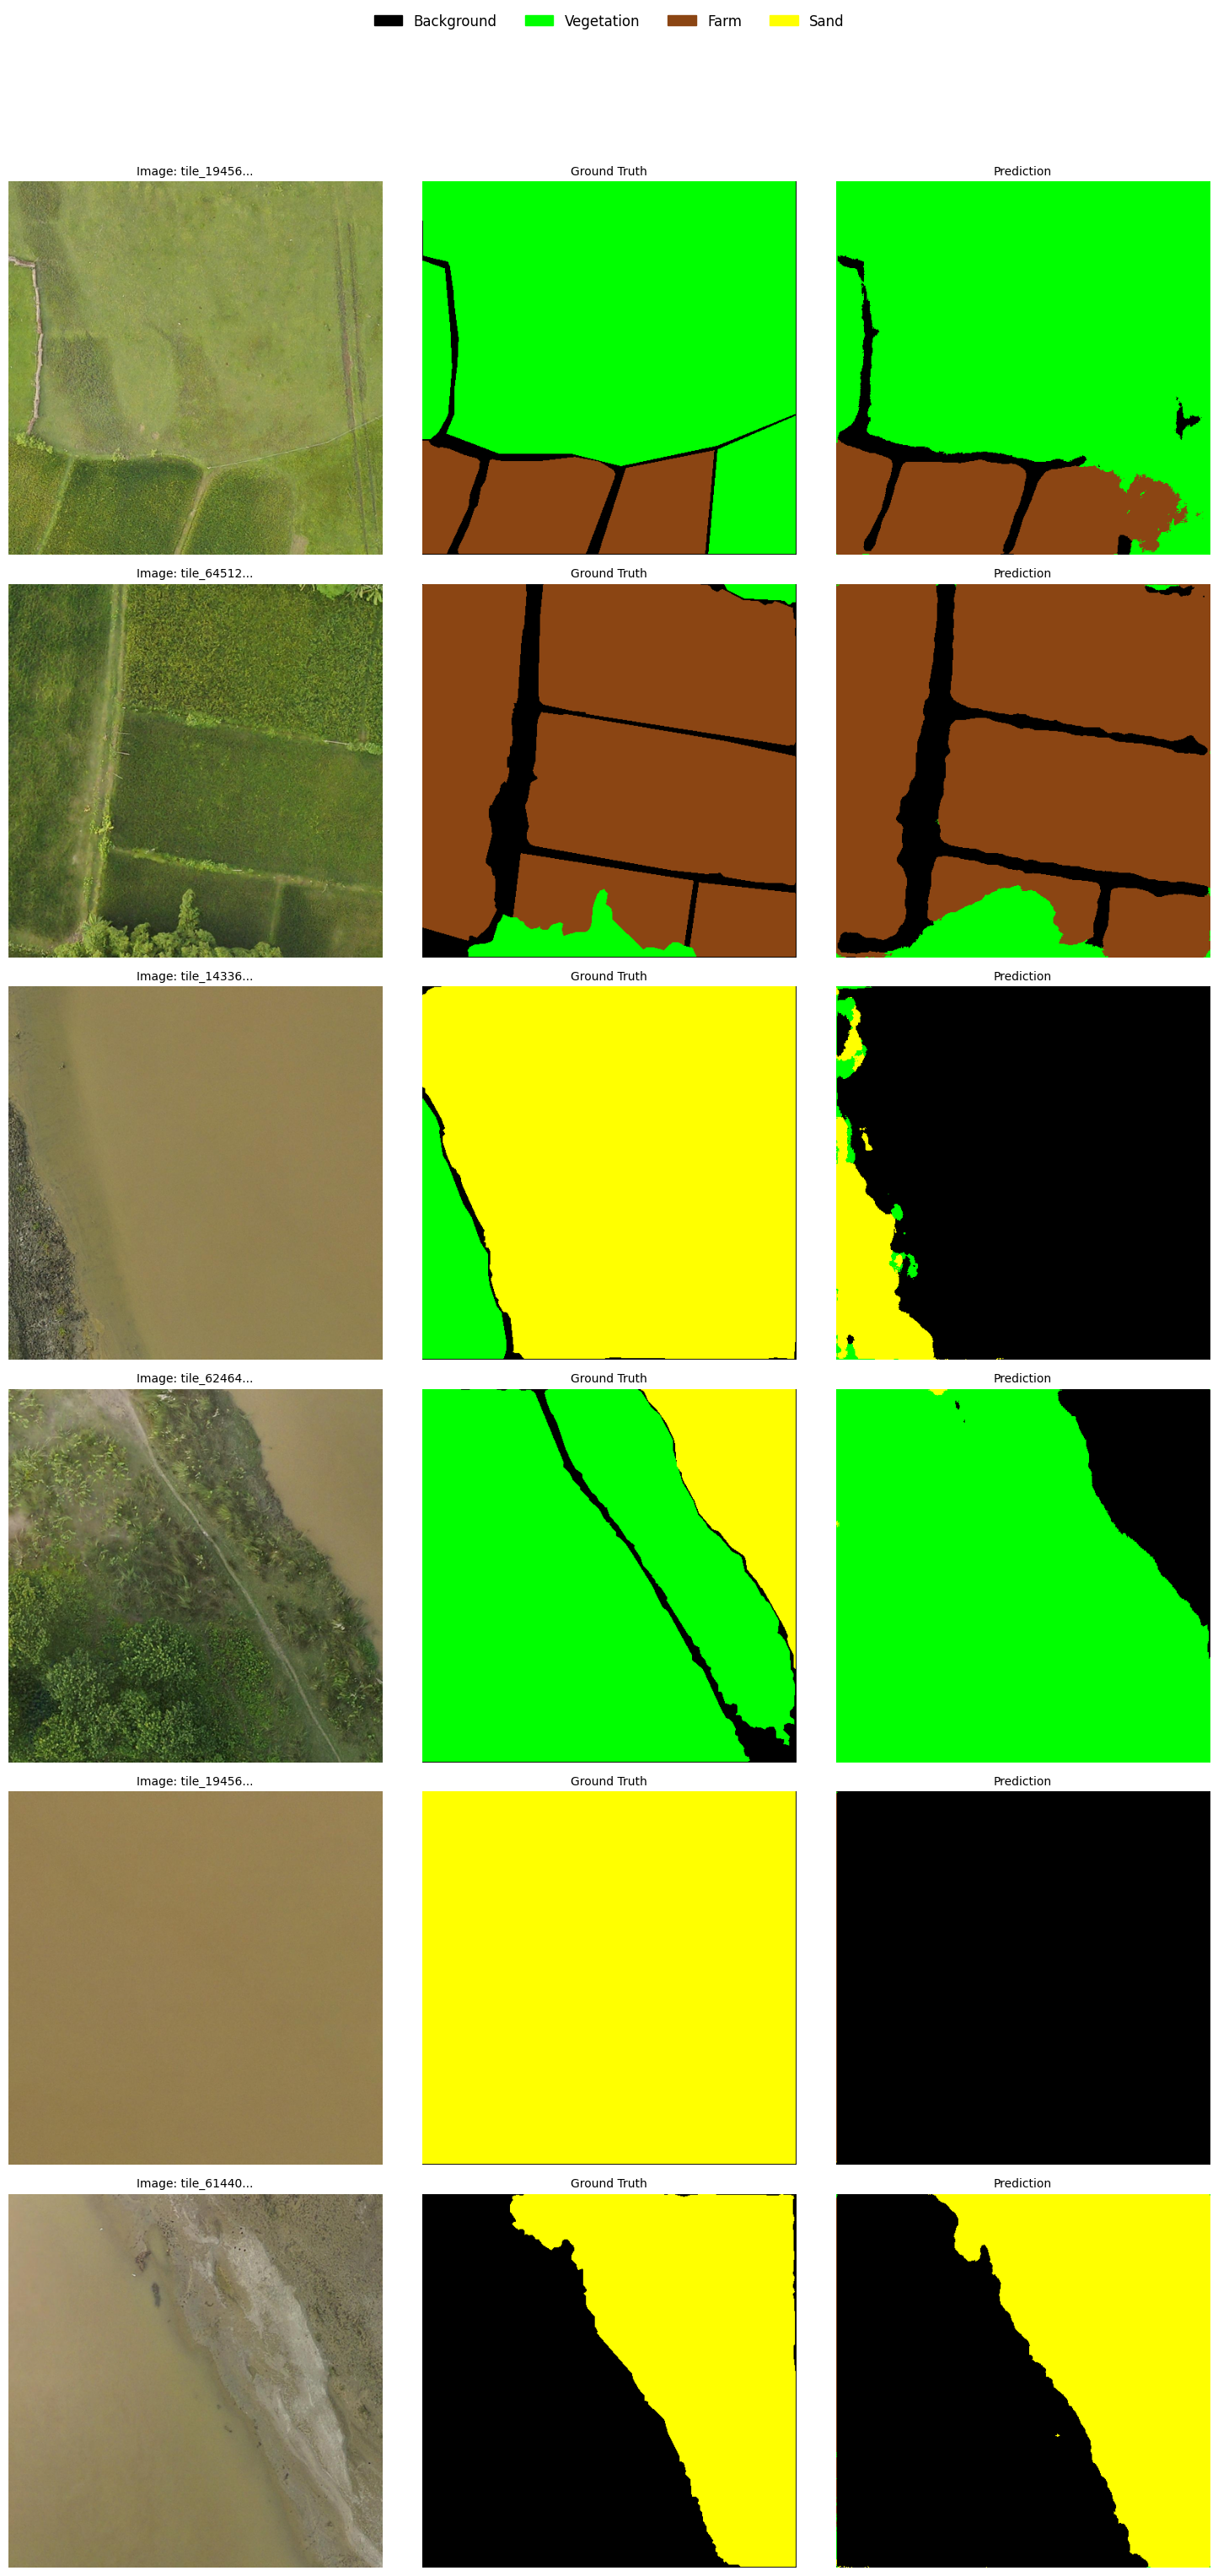

Inference complete. Image saved as 'inference_results_with_legend.png'.


In [ ]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # <--- Added for Legend
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

# ==========================================
# 1. CONFIGURATION & SETUP
# ==========================================
CONFIG = {
    "ROOT_DIR": "/content/valid",  # Path to test folder
    "IMG_SIZE": 512,
    "NUM_CLASSES": 4,             # 0:Back, 1:Veg, 2:Farm, 3:Sand
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "MODEL_PATH": "/content/unetplusplus_b4_best.pth",
    "ENCODER": "efficientnet-b4",
    "ENCODER_WEIGHTS": "imagenet"
}

# Define colors for visualization
# Format: [R, G, B]
CLASS_COLORS = np.array([
    [0, 0, 0],       # 0: Background (Black)
    [0, 255, 0],     # 1: Vegetation (Green)
    [139, 69, 19],   # 2: Farm (Brown)
    [255, 255, 0],   # 3: Sand (Yellow)
])

CLASS_NAMES = ["Background", "Vegetation", "Farm", "Sand"]

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================
def decode_segmap(mask):
    """
    Converts a 2D segmentation mask (H, W) with integer class IDs
    into an RGB image (H, W, 3) for visualization.
    """
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)

    for label_idx in range(CONFIG['NUM_CLASSES']):
        idx = (mask == label_idx)
        r[idx] = CLASS_COLORS[label_idx, 0]
        g[idx] = CLASS_COLORS[label_idx, 1]
        b[idx] = CLASS_COLORS[label_idx, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

def process_mask(mask_path):
    """
    Loads the raw mask and applies the same mapping logic used during training.
    """
    mask = np.array(Image.open(mask_path).convert("L"))

    new_mask = np.zeros_like(mask)
    # Apply exact mapping from Training Code
    new_mask[(mask == 1) | (mask == 2) | (mask == 5)] = 1 # Veg
    new_mask[mask == 3] = 2 # Farm
    new_mask[mask == 4] = 3 # Sand
    # Ignore indices mapping
    new_mask[mask == 6] = 0 # Treat boundary/ignore as background for viz
    new_mask[mask > 6] = 0

    return new_mask

def get_inference_transform():
    """Transform for input image only"""
    return A.Compose([
        A.Resize(height=CONFIG['IMG_SIZE'], width=CONFIG['IMG_SIZE']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

# ==========================================
# 3. INFERENCE LOOP
# ==========================================
def run_inference():
    print("--- Loading Model ---")
    # 1. Load Model Architecture
    model = smp.UnetPlusPlus(
        encoder_name=CONFIG['ENCODER'],
        encoder_weights=None,
        in_channels=3,
        classes=CONFIG['NUM_CLASSES']
    ).to(CONFIG['DEVICE'])

    # 2. Load Weights
    if os.path.exists(CONFIG['MODEL_PATH']):
        model.load_state_dict(torch.load(CONFIG['MODEL_PATH'], map_location=CONFIG['DEVICE']))
        print("Weights loaded successfully.")
    else:
        print(f"Error: Model path {CONFIG['MODEL_PATH']} not found!")
        return

    model.eval()
    transform = get_inference_transform()

    # 3. Get Test Images
    img_dir = os.path.join(CONFIG['ROOT_DIR'], "images")
    mask_dir = os.path.join(CONFIG['ROOT_DIR'], "masks")

    if not os.path.exists(img_dir):
        print(f"Error: Image directory {img_dir} not found.")
        return

    all_images = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])

    if len(all_images) == 0:
        print("No images found in test directory.")
        return

    # 4. Select Random Samples
    num_samples = min(6, len(all_images))
    selected_images = random.sample(all_images, num_samples)

    print(f"--- Displaying {num_samples} Random Predictions ---")

    # Create Figure
    fig = plt.figure(figsize=(15, 5 * num_samples))

    for i, img_name in enumerate(selected_images):
        mask_name = img_name.replace(".jpg", "_mask.png")
        img_path = os.path.join(img_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)

        # --- Preprocessing ---
        original_img = np.array(Image.open(img_path).convert("RGB"))
        original_img_resized = np.array(Image.fromarray(original_img).resize((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])))

        if os.path.exists(mask_path):
            gt_mask_raw = process_mask(mask_path)
            gt_mask_resized = np.array(Image.fromarray(gt_mask_raw).resize((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']), resample=Image.NEAREST))
            gt_rgb = decode_segmap(gt_mask_resized)
        else:
            gt_rgb = np.zeros((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], 3))

        # Preprocess for Model
        augmentations = transform(image=original_img)
        input_tensor = augmentations["image"].unsqueeze(0).to(CONFIG['DEVICE'])

        # --- Prediction ---
        with torch.no_grad():
            output = model(input_tensor)
            pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

        pred_rgb = decode_segmap(pred_mask)

        # --- Plotting ---
        # Column 1: Original
        ax1 = plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(original_img_resized)
        plt.title(f"Image: {img_name[:10]}...", fontsize=10)
        plt.axis("off")

        # Column 2: GT
        ax2 = plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(gt_rgb)
        plt.title("Ground Truth", fontsize=10)
        plt.axis("off")

        # Column 3: Pred
        ax3 = plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_rgb)
        plt.title("Prediction", fontsize=10)
        plt.axis("off")

    # --- ADD VISUAL LEGEND ---
    # Create proxy artists (colored rectangles) for the legend
    patches = [
        mpatches.Patch(color=CLASS_COLORS[i]/255.0, label=CLASS_NAMES[i])
        for i in range(len(CLASS_NAMES))
    ]

    # Add legend to the top of the figure
    fig.legend(handles=patches, loc='upper center', ncol=len(CLASS_NAMES),
               bbox_to_anchor=(0.5, 1.02), fontsize=12, frameon=False)

    # Adjust layout to make room for legend
    plt.tight_layout(rect=[0, 0.0, 1, 0.96])

    # Save and Show
    plt.savefig("inference_results_with_legend.png", bbox_inches='tight')
    plt.show()

    print("Inference complete. Image saved as 'inference_results_with_legend.png'.")

if __name__ == "__main__":
    run_inference()

Loading Unet++ (efficientnet-b4) from unetplusplus_b4_best.pth...
Model loaded successfully.
Scanning map... (Pixel Area: 0.0019 m²)

--- Tile at (256, 256) ---
Farmland: 188.6 m² lost (out of 448.9 m²)
Vegetation: 0.1 m² lost (out of 0.1 m²)


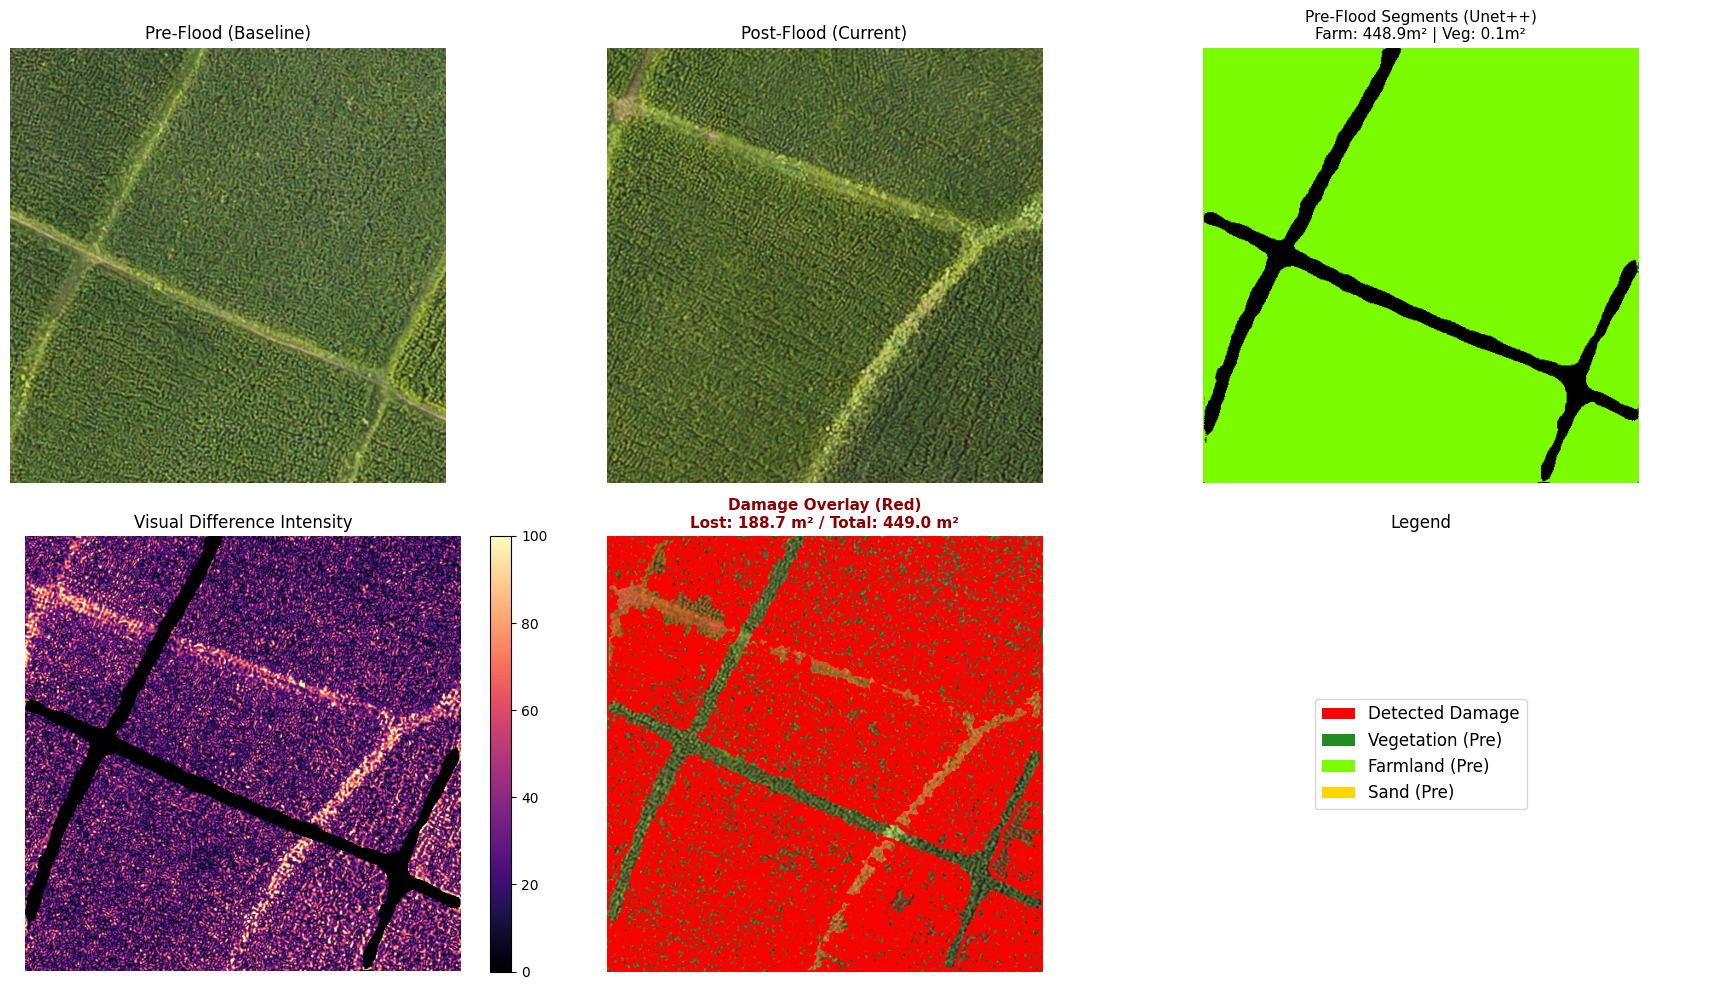

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
import rasterio
from rasterio.windows import Window
import albumentations as A
from albumentations.pytorch import ToTensorV2
from matplotlib.patches import Patch
import segmentation_models_pytorch as smp

# ==========================================
# 1. CONFIGURATION
# ==========================================
CONFIG = {
    # Update these paths to your actual Kaggle/Local paths
    "PRE_ORTHO_PATH": "/content/tile_0813.tif",
    "POST_ORTHO_PATH": "/content/tile_0814.tif",
    "MODEL_PATH": "unetplusplus_b4_best.pth", # Your Phase 1 Model Path

    "TILE_SIZE": 512,
    "NUM_CLASSES": 4,        # 0:Back, 1:Veg, 2:Farm, 3:Sand
    "ENCODER": "efficientnet-b4",
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "NUM_EXAMPLES": 5,       # How many examples to display

    "COLOR_DIFF_THRESHOLD": 30.0, # Sensitivity for change detection
    "MIN_AREA_THRESHOLD_M2": 10.0 # Minimum loss area to trigger display
}

# Visualization Settings
ID2LABEL = {0: "Background", 1: "Vegetation", 2: "Farmland", 3: "Sand"}
# Colors [R, G, B]
CLASS_COLORS = {
    0: [0, 0, 0],       # Black
    1: [34, 139, 34],   # Forest Green
    2: [124, 252, 0],   # Lawn Green
    3: [255, 215, 0]    # Gold/Sand
}

# ==========================================
# 2. ADVANCED ANALYSIS PIPELINE
# ==========================================
class FloodDamageEstimator:
    def __init__(self, config):
        self.config = config
        self.device = config['DEVICE']

        # Preprocessing (Must match training)
        self.transform = A.Compose([
            A.Resize(height=config['TILE_SIZE'], width=config['TILE_SIZE']),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

        print(f"Loading Unet++ ({config['ENCODER']}) from {config['MODEL_PATH']}...")

        # Initialize SMP Model
        self.model = smp.UnetPlusPlus(
            encoder_name=config['ENCODER'],
            encoder_weights=None, # Weights loaded manually below
            in_channels=3,
            classes=config['NUM_CLASSES']
        )

        try:
            # Load Weights
            state_dict = torch.load(config['MODEL_PATH'], map_location=self.device)
            self.model.load_state_dict(state_dict)
            self.model.to(self.device)
            self.model.eval()
            print("Model loaded successfully.")
        except Exception as e:
            print(f"Error loading model: {e}")
            # Optional: Continue if testing without weights, but warn heavily
            # raise e

    def is_valid_tile(self, image):
        """Skip empty or mostly black tiles"""
        if image is None: return False
        if image.shape[0] == 0 or image.shape[1] == 0: return False
        non_black = np.sum(image, axis=2) > 10
        # If more than 80% of the tile is valid data
        if np.mean(non_black) < 0.8: return False
        return True

    def get_segmentation(self, image_np):
        """Run Inference on a single tile"""
        aug = self.transform(image=image_np)
        img_tensor = aug["image"].unsqueeze(0).to(self.device)

        with torch.no_grad():
            logits = self.model(img_tensor)
            # Interpolate back to original size if necessary (though here it's fixed 512)
            logits = F.interpolate(logits, size=image_np.shape[:2], mode='bilinear', align_corners=False)
            pred_mask = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

        return pred_mask

    def calculate_lab_difference(self, img_pre, img_post):
        """Calculate perceptual color difference in LAB space"""
        lab_pre = cv2.cvtColor(img_pre, cv2.COLOR_RGB2LAB).astype(np.float32)
        lab_post = cv2.cvtColor(img_post, cv2.COLOR_RGB2LAB).astype(np.float32)
        # Euclidean distance in LAB space
        delta_e = np.sqrt(np.sum((lab_pre - lab_post) ** 2, axis=2))
        return delta_e

    def analyze_segment_change(self, img_pre, img_post, pre_mask):
        """
        Identify damage ONLY within the Farmland (2) or Vegetation (1) regions
        defined by the pre_mask.
        """
        # Interest Mask: Only care about pixels that were Veg or Farm
        roi_mask = (pre_mask == 1) | (pre_mask == 2)

        if np.sum(roi_mask) == 0:
            return np.zeros_like(pre_mask, dtype=bool), np.zeros_like(pre_mask, dtype=np.float32)

        diff_map = self.calculate_lab_difference(img_pre, img_post)

        masked_diff = np.zeros_like(diff_map)
        masked_diff[roi_mask] = diff_map[roi_mask] # Only keep diffs in ROI

        # Thresholding to find 'Damage'
        is_damaged = masked_diff > self.config['COLOR_DIFF_THRESHOLD']

        return is_damaged, masked_diff

    def process_and_visualize(self):
        # Open both large Orthomosaics
        with rasterio.open(self.config['PRE_ORTHO_PATH']) as src_pre, \
             rasterio.open(self.config['POST_ORTHO_PATH']) as src_post:

            # Get Real-world pixel resolution
            res_x, res_y = src_pre.res
            pixel_area_m2 = abs(res_x * res_y)

            width, height = src_pre.width, src_pre.height
            # Define scan region (middle 50% of map to find good examples)
            start_x, end_x = width // 4, (width // 4) * 3
            start_y, end_y = height // 4, (height // 4) * 3

            step = self.config['TILE_SIZE']
            count = 0

            print(f"Scanning map... (Pixel Area: {pixel_area_m2:.4f} m²)")

            for x in range(start_x, end_x, step):
                if count >= self.config['NUM_EXAMPLES']: break
                for y in range(start_y, end_y, step):
                    if count >= self.config['NUM_EXAMPLES']: break

                    window = Window(x, y, self.config['TILE_SIZE'], self.config['TILE_SIZE'])

                    try:
                        # Read tiles
                        img_pre = src_pre.read(window=window, boundless=True, fill_value=0)
                        img_post = src_post.read(window=window, boundless=True, fill_value=0)

                        # Channels first -> Channels last
                        img_pre = np.moveaxis(img_pre, 0, -1).astype(np.uint8)[:, :, :3]
                        img_post = np.moveaxis(img_post, 0, -1).astype(np.uint8)[:, :, :3]

                        if not self.is_valid_tile(img_pre) or not self.is_valid_tile(img_post):
                            continue

                        # 1. Inference: What was here before?
                        pre_mask = self.get_segmentation(img_pre)

                        # 2. Calculate Baseline Areas
                        farm_area_total = np.sum(pre_mask == 2) * pixel_area_m2
                        veg_area_total = np.sum(pre_mask == 1) * pixel_area_m2

                        # 3. Change Detection
                        is_damaged, diff_map = self.analyze_segment_change(img_pre, img_post, pre_mask)

                        # 4. Calculate Damage Areas
                        farm_damage = np.sum((pre_mask == 2) & is_damaged) * pixel_area_m2
                        veg_damage = np.sum((pre_mask == 1) & is_damaged) * pixel_area_m2

                        # 5. Display only if significant damage found
                        if farm_damage > self.config['MIN_AREA_THRESHOLD_M2'] or veg_damage > self.config['MIN_AREA_THRESHOLD_M2']:
                            count += 1

                            stats = {
                                "farm_loss": farm_damage,
                                "veg_loss": veg_damage,
                                "farm_total": farm_area_total,
                                "veg_total": veg_area_total
                            }

                            print(f"\n--- Tile at ({x}, {y}) ---")
                            print(f"Farmland: {farm_damage:.1f} m² lost (out of {farm_area_total:.1f} m²)")
                            print(f"Vegetation: {veg_damage:.1f} m² lost (out of {veg_area_total:.1f} m²)")

                            self.visualize_tile(img_pre, img_post, pre_mask, diff_map, is_damaged, stats)

                    except Exception as e:
                        # Often happens at map edges
                        continue

    def colorize_mask(self, mask_2d):
        """Convert class ID mask to RGB for display"""
        h, w = mask_2d.shape
        color_mask = np.zeros((h, w, 3), dtype=np.uint8)
        for cls_id, color in CLASS_COLORS.items():
            color_mask[mask_2d == cls_id] = color
        return color_mask

    def visualize_tile(self, pre, post, pre_mask, diff_map, is_damaged, stats):
        """Plot the 6-panel analysis"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))

        # 1. Pre Flood
        axes[0, 0].imshow(pre)
        axes[0, 0].set_title("Pre-Flood (Baseline)")
        axes[0, 0].axis('off')

        # 2. Post Flood
        axes[0, 1].imshow(post)
        axes[0, 1].set_title("Post-Flood (Current)")
        axes[0, 1].axis('off')

        # 3. Model Prediction (Mask)
        axes[0, 2].imshow(self.colorize_mask(pre_mask))
        axes[0, 2].set_title(
            f"Pre-Flood Segments (Unet++)\n"
            f"Farm: {stats['farm_total']:.1f}m² | Veg: {stats['veg_total']:.1f}m²",
            fontsize=11
        )
        axes[0, 2].axis('off')

        # 4. Color Difference Map
        # Visualize the raw LAB difference to show "intensity" of change
        im = axes[1, 0].imshow(diff_map, cmap='magma', vmin=0, vmax=100)
        axes[1, 0].set_title("Visual Difference Intensity")
        axes[1, 0].axis('off')
        plt.colorbar(im, ax=axes[1, 0], fraction=0.046)

        # 5. Damage Overlay
        overlay = post.copy()
        damage_mask_uint8 = is_damaged.astype(np.uint8)

        # Draw Contours for sharp edges
        contours, _ = cv2.findContours(damage_mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, (255, 0, 0), 2)

        # Semi-transparent red fill
        overlay_layer = overlay.copy()
        overlay_layer[is_damaged] = [255, 0, 0] # Red
        cv2.addWeighted(overlay_layer, 0.4, overlay, 0.6, 0, overlay)

        total_loss = stats['farm_loss'] + stats['veg_loss']
        total_area = stats['farm_total'] + stats['veg_total']

        axes[1, 1].imshow(overlay)
        axes[1, 1].set_title(
            f"Damage Overlay (Red)\n"
            f"Lost: {total_loss:.1f} m² / Total: {total_area:.1f} m²",
            fontsize=11, fontweight='bold', color='darkred'
        )
        axes[1, 1].axis('off')

        # 6. Legend
        legend_elements = [
            Patch(facecolor='red', label='Detected Damage'),
            Patch(facecolor=np.array(CLASS_COLORS[1])/255, label=f"Vegetation (Pre)"),
            Patch(facecolor=np.array(CLASS_COLORS[2])/255, label=f"Farmland (Pre)"),
            Patch(facecolor=np.array(CLASS_COLORS[3])/255, label=f"Sand (Pre)")
        ]
        axes[1, 2].legend(handles=legend_elements, loc='center', fontsize=12)
        axes[1, 2].axis('off')
        axes[1, 2].set_title("Legend")

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    # Check if Orthomosaics exist (Optional safety check)
    if os.path.exists(CONFIG['PRE_ORTHO_PATH']) or os.path.exists(CONFIG['MODEL_PATH']):
        estimator = FloodDamageEstimator(CONFIG)
        estimator.process_and_visualize()
    else:
        print("Warning: Paths not found. Please check CONFIG paths.")

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 44.4 MB/s eta 0:00:00
